# TabPFN
**TabPFN**, or **Tabular Prior-Data Fitted Network**, is a pre-trained neural network designed for classification, utilising synthetic data. This model is intended for rapid application to new datasets without the necessity for hyperparameter tuning. Its prediction process involves a single forward pass with the pre-trained network, eliminating the need for any dataset-specific training.

>**Please note, you have run first cell to install tabpfn library in order to execute this notebook.**

# Import all necessary libraries and additional functions 

In [1]:
# This library must to be present in the environment to run this notebook
#!pip install tabpfn

In [2]:
import warnings  # Suppress the warnings
warnings.filterwarnings('ignore') 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Import necessary libraries
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabpfn import TabPFNClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

seed=9

In [3]:
def plot_confusion_matrix_alt(c_matrix, labels, main_title=None):
    """
    sns.heatmap didn't show all values, so this is malual heatmap,
    that works properly.
    """
    fig, ax = plt.subplots()
    cax = ax.matshow(c_matrix, cmap='Blues')
    # Add annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i==j:
                color='white'
            else:
                color='black'
            ax.text(j, i, c_matrix[i, j], va='center', ha='center', color=color, fontsize=12)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    if main_title:
        plt.suptitle(main_title, fontsize=16, y=1.05)
    plt.show()

## Data loading

In [4]:
# Load a dataset
df = pd.read_csv('data_clean.csv')
# Shuffle rows
df = shuffle(df, random_state=42)
df.head()

,County,Year,Make,Model,EVType,CAFV,Range,MSRP,District,Provider
79969,5,2012,25,70,0,1,73,0,18.0,36
18786,33,2021,31,75,0,0,0,0,35.0,71
15184,16,2023,24,80,1,1,38,0,11.0,72
24147,31,2022,15,121,1,0,22,0,7.0,2
134694,16,2018,31,74,0,1,238,0,41.0,72


In [5]:
# Take only first 30,000 rows
df_cut = df.head(30000)
# Checking class imbalance
ratio_check=df_cut.CAFV.value_counts()[0]/df_cut.CAFV.value_counts()[1]
print("Ratio between the classes:", ratio_check)
# df.CAFV.value_counts()
# Define features and target variable
X = df_cut.drop('CAFV', axis=1)
y = df_cut['CAFV']
X.shape, y.shape

Ratio between the classes: 1.477291494632535


((30000, 9), (30000,))

## Run TabPFN Classification

In [8]:
# Declare additional functions
from time import sleep
def run_classifier(X_train, X_test, y_train, y_test, N_ensemble_configurations):
    time_1 = time()
    # Create TabPFNClassifier instance
    classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=N_ensemble_configurations)
    # Fit our training data
    history = classifier.fit(X_train, y_train)
    time_2 = time()
    # Predict on testing data
    y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)
    # Calculate evaluation metrics
    acc = accuracy_score(y_test, y_eval)
    precision = precision_score(y_test.to_numpy(), y_eval)
    recall = recall_score(y_test, y_eval)
    # Calculating confusion_matrix
    c_matrix = confusion_matrix(y_test, y_eval)
    # Save results
    iter_result = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        'Time to compile and fit model': time_2 - time_1,
        'N_ensemble_configurations': N_ensemble_configurations,
        "confusion_matrix": c_matrix,
        'classifier': classifier,
    }

    return iter_result
    

def evaluate_classifier(X, y, train_size, N_ensemble_configurations):
    """
    Evaluates a TabPFNClassifier on varying training sizes and N_ensemble_configurations.

    :param X: Input features.
    :param y: Target variable.
    :param train_sizes: List of training sizes to evaluate. Default is [0.01, 0.02, 0.03].
    :param N_ensemble_configurations: Number of ensemble configurations for TabPFNClassifier.

    :return results: List of dictionaries containing evaluation results for each iteration.
     """
    # To store results
    results = []
    classifiers = []
    if isinstance(train_size, float) and isinstance(N_ensemble_configurations, int):
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
        print("Train shape:", X_train.shape, y_train.shape)
        print("Test shape:", X_test.shape, y_test.shape)
        result = run_classifier(X_train, X_test, y_train, y_test, N_ensemble_configurations=N_ensemble_configurations)
        result['Train size'] = train_size
        result["Train shape"] = y_train.shape
        return result
    
    for tr_size in train_size:
        for n_conf in N_ensemble_configurations:
            print(f'\tTrain size: {tr_size}, N_ensemble_configurations: {n_conf}')
            # Split the data into training and test sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=tr_size, random_state=seed)
            print("* Train shape:", y_train.shape[0])
            print("* Test shape:", y_test.shape[0])
            eval_res = run_classifier(X_train, X_test, y_train, y_test, N_ensemble_configurations=n_conf)
            eval_res['Train size'] = tr_size
            eval_res["Train shape"] = y_train.shape
            results.append(eval_res)
            
            # to prevent kennel from crush :)
            sleep(10)

    return results

In [10]:
# This cell takes  of time to execute!
# Setting parameters to evaluate
test_train_size = [ .01, .02, .03,
                   0.03414]  # prefered maximum of datarows (1024)

n_ensemble_configurations = [4, 9, 16]
# No point to set up N_ensemble_configurations more 18,
# because it will exceed the total number of unique combinations,
# and no further averaging is applied in the ensembling process.


test_results = evaluate_classifier(X, y, test_train_size, n_ensemble_configurations)

	Train size: 0.01, N_ensemble_configurations: 4
* Train shape: 300
* Test shape: 29700
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.01, N_ensemble_configurations: 9
* Train shape: 300
* Test shape: 29700
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.01, N_ensemble_configurations: 16
* Train shape: 300
* Test shape: 29700
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.02, N_ensemble_configurations: 4
* Train shape: 600
* Test shape: 29400
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.02, N_ensemble_configurations: 9
* Train shape: 600
* Test shape: 29400
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.02, N_ensemble_configurations: 16
* Train shape: 600
* Test shape: 29400
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.03, N_ensemble_configurations: 4
* Train shape: 900
* Test shape: 29100
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.03, N_ensemble_configurations: 9
* Train shape: 900
* Test shape: 29100
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.03, N_ensemble_configurations: 16
* Train shape: 900
* Test shape: 29100
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.03414, N_ensemble_configurations: 4
* Train shape: 1024
* Test shape: 28976
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.03414, N_ensemble_configurations: 9
* Train shape: 1024
* Test shape: 28976
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

	Train size: 0.03414, N_ensemble_configurations: 16
* Train shape: 1024
* Test shape: 28976
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

Accuracy: 0.9933333333333333
Precision: 0.9894649523019494
Recall: 0.9940828402366864
Time to compile and fit model: 0.26883792877197266
N_ensemble_configurations: 4


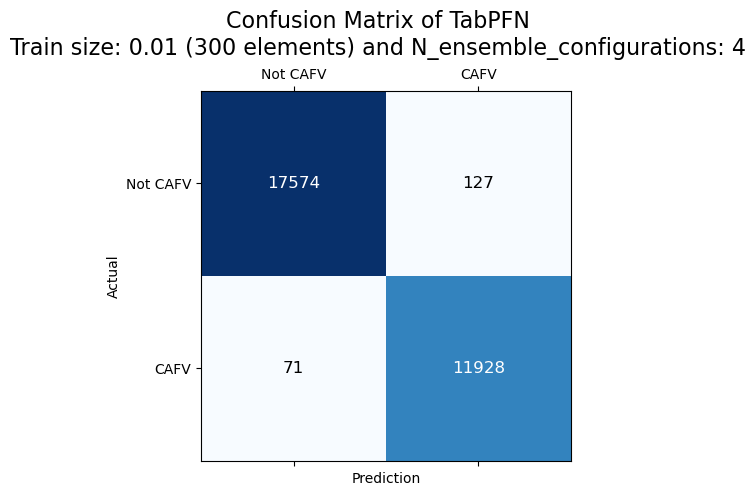

Train size: 0.01
Train shape: (300,)
Accuracy: 0.9943434343434343
Precision: 0.9908721267944569
Recall: 0.9951662638553213
Time to compile and fit model: 0.11926007270812988
N_ensemble_configurations: 9


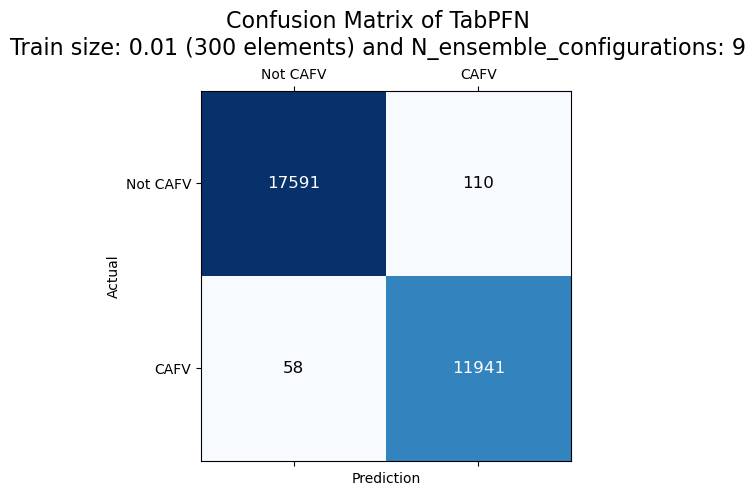

Train size: 0.01
Train shape: (300,)
Accuracy: 0.9946464646464647
Precision: 0.9909603582683696
Recall: 0.9958329860821735
Time to compile and fit model: 0.13379311561584473
N_ensemble_configurations: 16


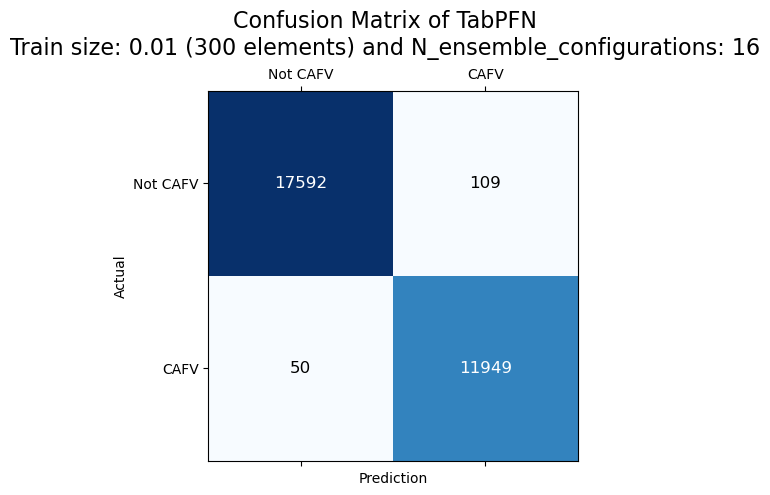

Train size: 0.01
Train shape: (300,)
Accuracy: 0.9999659863945578
Precision: 1.0
Recall: 0.9999157752884696
Time to compile and fit model: 0.14848589897155762
N_ensemble_configurations: 4


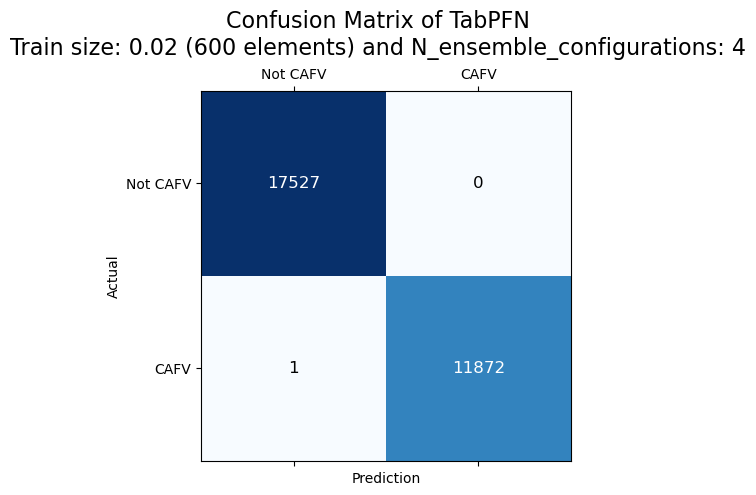

Train size: 0.02
Train shape: (600,)
Accuracy: 0.9999659863945578
Precision: 0.9999157823816742
Recall: 1.0
Time to compile and fit model: 0.1201331615447998
N_ensemble_configurations: 9


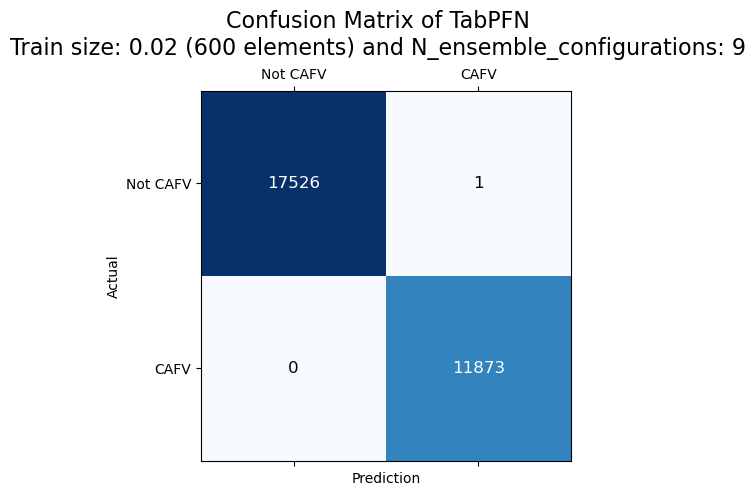

Train size: 0.02
Train shape: (600,)
Accuracy: 0.9999659863945578
Precision: 0.9999157823816742
Recall: 1.0
Time to compile and fit model: 0.15591096878051758
N_ensemble_configurations: 16


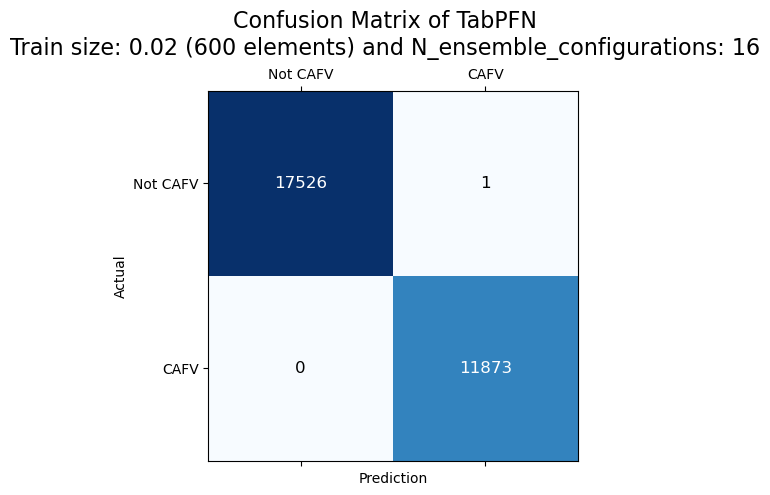

Train size: 0.02
Train shape: (600,)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Time to compile and fit model: 0.5016260147094727
N_ensemble_configurations: 4


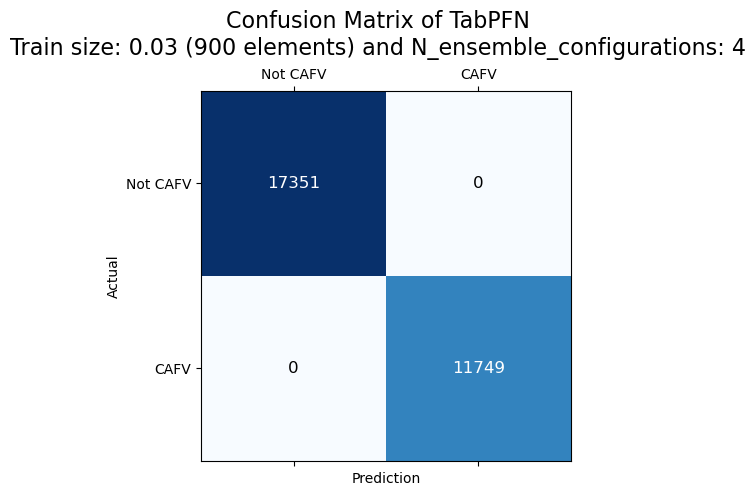

Train size: 0.03
Train shape: (900,)
Accuracy: 0.9999656357388316
Precision: 0.9999148936170212
Recall: 1.0
Time to compile and fit model: 0.1166679859161377
N_ensemble_configurations: 9


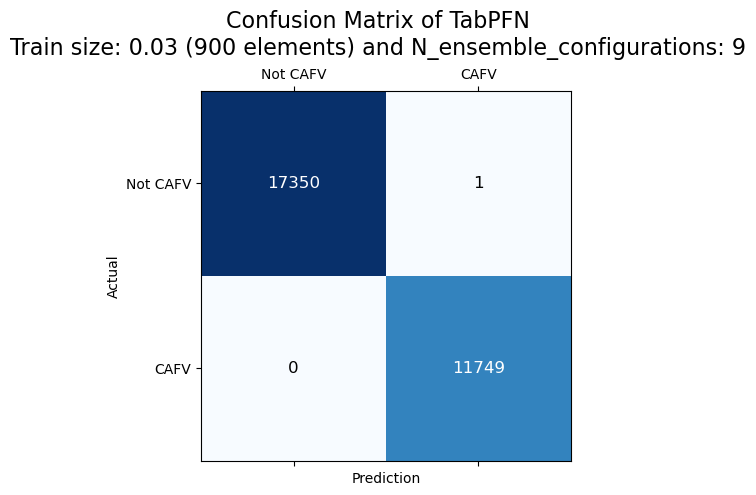

Train size: 0.03
Train shape: (900,)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Time to compile and fit model: 0.37502098083496094
N_ensemble_configurations: 16


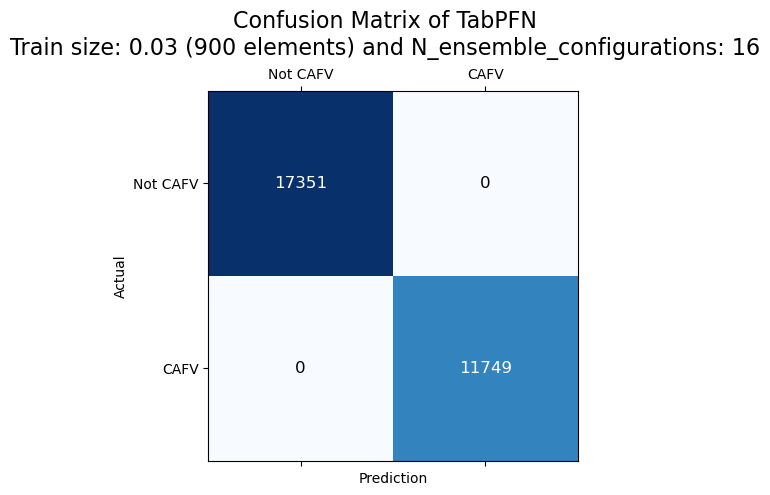

Train size: 0.03
Train shape: (900,)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Time to compile and fit model: 1.2536940574645996
N_ensemble_configurations: 4


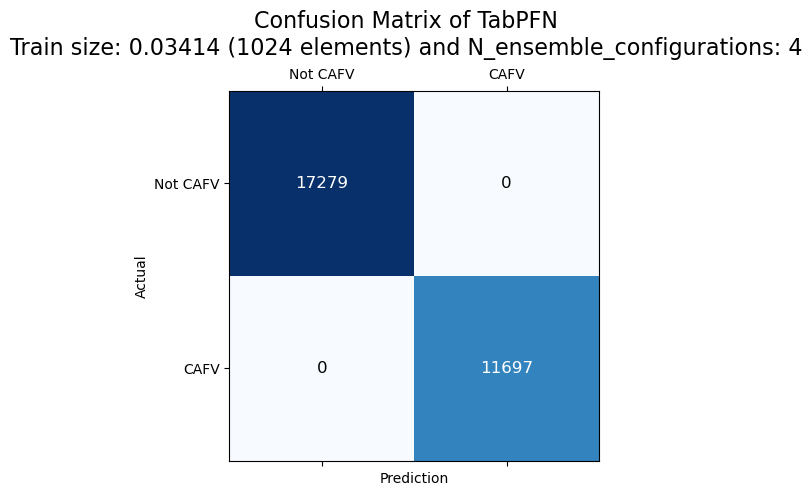

Train size: 0.03414
Train shape: (1024,)
Accuracy: 0.9999654886802871
Precision: 0.999914515301761
Recall: 1.0
Time to compile and fit model: 0.11880707740783691
N_ensemble_configurations: 9


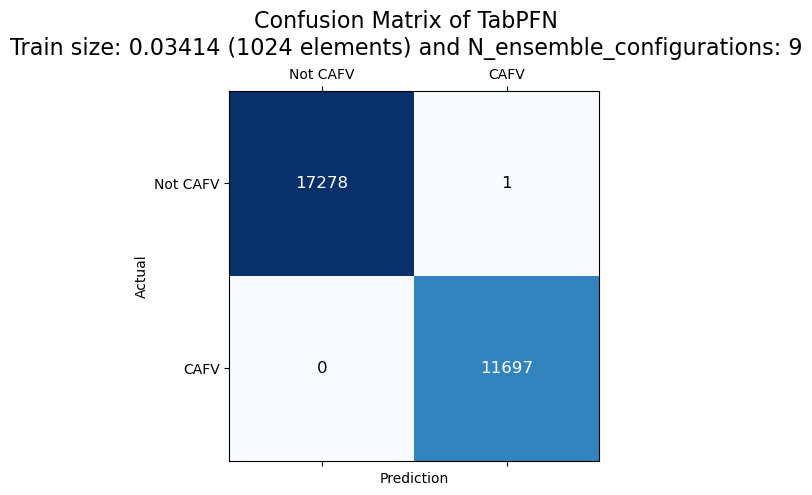

Train size: 0.03414
Train shape: (1024,)
Accuracy: 0.9999654886802871
Precision: 0.999914515301761
Recall: 1.0
Time to compile and fit model: 0.4784369468688965
N_ensemble_configurations: 16


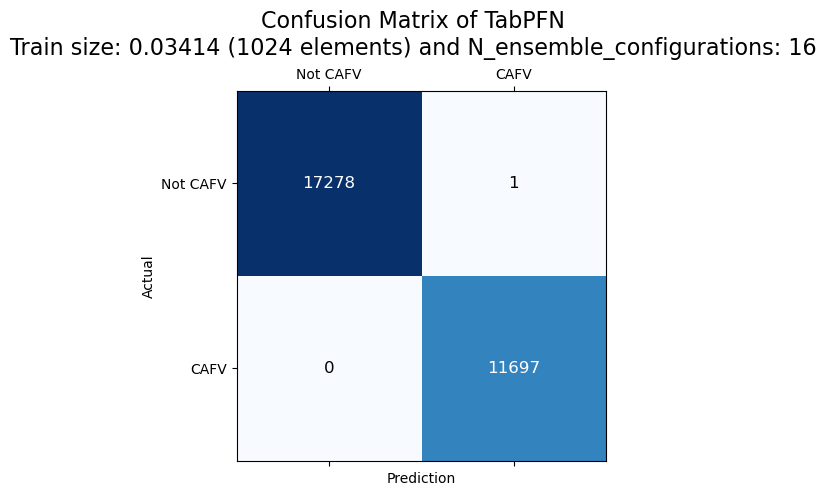

Train size: 0.03414
Train shape: (1024,)


In [33]:
labels = ['Not CAFV', 'CAFV']
accuracy_plot, n_comp_plot, train_s = [], [], []
for elem in test_results:
    accuracy_plot.append(elem['Accuracy']*100)
    n_comp_plot.append(elem['N_ensemble_configurations'])
    train_s.append(elem['Train size'])
    for key, val in elem.items():
        if key == 'confusion_matrix':
            # Plot confusion matrix
            plot_confusion_matrix_alt(val, labels,
                                      main_title=f'Confusion Matrix of TabPFN\nTrain size: {elem["Train size"]} ({elem["Train shape"][0]} elements) and N_ensemble_configurations: {elem["N_ensemble_configurations"]}')
        elif key == 'classifier':
            pass
        else:
            # Print the metrics
            print(f'{key}: {val}')

As we can see, the maximum split of 3% (900-1024 rows) providing maximum accuracy.


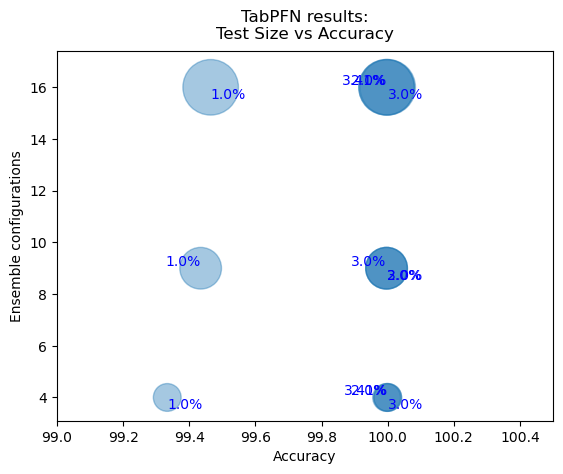

In [82]:
# Plot our test results
pr_n_comp_plot = [x* 100 for x in n_comp_plot]
plt.scatter(accuracy_plot, n_comp_plot,  s=pr_n_comp_plot, alpha=0.4,) #, marker='.') # , linestyle='-')
plt.title('TabPFN results:\nTest Size vs Accuracy', y=1.01)
plt.ylabel('Ensemble configurations')
plt.xlabel('Accuracy')
plt.ylim(3.1, 17.4)
plt.xlim(round(min(accuracy_plot)), 100.5)
# Add values of each point 
i = 0
for x, y, z in zip(accuracy_plot, n_comp_plot, train_s):
    if i % 2:
        plt.text(x, y, f'{round(z*100,2)}%', ha='right', va='bottom', color='blue')
    else:
        plt.text(x, y, f'{round(z,2)*100}%', ha='left', va='top', color='blue')
    i +=1

plt.show()

As we can see, the maximum split of 2-3% (600-1024 rows) gives us maximum accuracy, no matter how many numbers of ensemble configurations we specify.

## Evaluating the model performance on other part of dataset
Since initially we took only 30,000 rows of data, let's take the rest of it and examine it.

In [83]:
# Take other part of dataset
else_df = df.tail(len(df)-30000)
print(len(else_df), 'rows.')
else_df = shuffle(else_df, random_state=seed)
else_df.head()

123491 rows.


,County,Year,Make,Model,EVType,CAFV,Range,MSRP,District,Provider
130828,28,2021,6,17,0,0,0,0,40.0,71
31613,16,2019,31,72,0,1,220,0,46.0,56
117135,16,2023,31,75,0,0,0,0,46.0,56
21444,16,2014,4,58,1,1,72,0,37.0,56
109489,12,2011,6,119,1,1,35,0,13.0,70


In [84]:
# Get parameters with highest accuracy
best_param = max(test_results, key=lambda x: x['Accuracy'])
best_train_size = best_param['Train size']
best_n_conf = best_param['N_ensemble_configurations']
best_param

{'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'Time to compile and fit model': 0.5016260147094727,
 'N_ensemble_configurations': 4,
 'confusion_matrix': array([[17351,     0],
        [    0, 11749]]),
 'classifier': TabPFNClassifier(N_ensemble_configurations=4),
 'Train size': 0.03,
 'Train shape': (900,)}

In [85]:
# Split data
X = else_df.drop('CAFV', axis=1)
y = else_df['CAFV']
# Execute prediction on previously trained classifier
final_eval_results = best_param['classifier'].predict(X, return_winning_probability=True)

/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reen

/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jts/anaconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

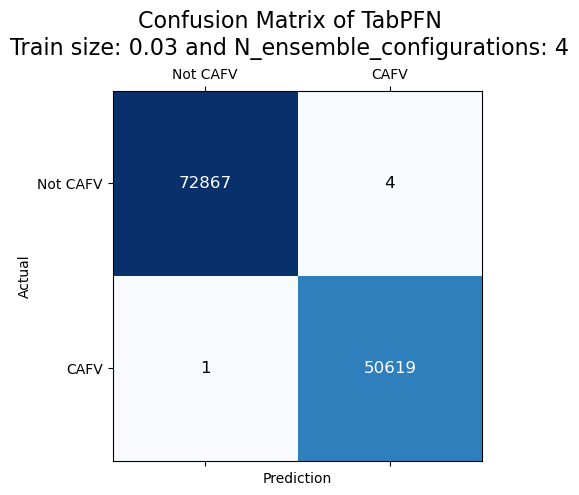

Training Accuracy: 100.0%
Testing Accuracy: 99.996%
Precision: 0.9999
Recall: 1.0000


In [103]:
labels = ['Not CAFV', 'CAFV']
# Calculate evaluation metrics
y_pred=final_eval_results[0]
acc = accuracy_score(y.to_numpy(), y_pred)
precision = precision_score(y.to_numpy(), y_pred)
recall = recall_score(y, y_pred)
# Calculating confusion_matrix
c_matrix = confusion_matrix(y, y_pred)

# Print
plot_confusion_matrix_alt(c_matrix, labels, main_title=f'Confusion Matrix of TabPFN\nTrain size: {best_train_size} and N_ensemble_configurations: {best_n_conf}')
print(f"Training Accuracy: {round(best_param['Accuracy']*100, 4)}%")
print(f"Testing Accuracy: {round(acc*100, 4)}%")
print(f"Precision: {precision:.4f}") # fraction of positive predictions which are correct
print(f"Recall: {recall:.4f}") # True positive rate 